<a href="https://colab.research.google.com/github/PabloParadaSouto/Automatica/blob/master/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Primero hacemos las instalaciones necesarias ....

In [ ]:


!apt update
#!apt install xvfb
#!pip install pyvirtualdisplay
!pip install gym[toy_text]
!pip install pyglet~=1.3.2
!apt install -y graphviz
!pip install flax
!pip install graphviz
!pip install pyvirtualdisplay
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install 'gym[atari]'
!pip install -U dopamine-rl
!pip install pyvirtualdisplay

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,357 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,920 kB]
Fetched 3,510 kB in 2s (1,795 kB/s)
Reading package lists... Do

ERROR: Operation cancelled by user


Enlace importante:

https://colab.research.google.com/github/psc-g/intro_to_rl/blob/master/Introduction_to_reinforcement_learning.ipynb#scrollTo=inwNVOucQ6gr



Vamos a crear nuestra versión de la red DQN para el problema, para ello nos fijamos en la solución que aparece más abajo, y la reescribimos en nuestro cuaderno tratando de entender las cosas:


https://medium.com/analytics-vidhya/solving-open-ais-cartpole-using-reinforcement-learning-part-2-73848cbda4f1

https://github.com/maciejbalawejder/Reinforcement-Learning-Collection/blob/main/DQN/DQN.ipynb

Os pongo un ejemplo de partida:


KeyboardInterrupt: 

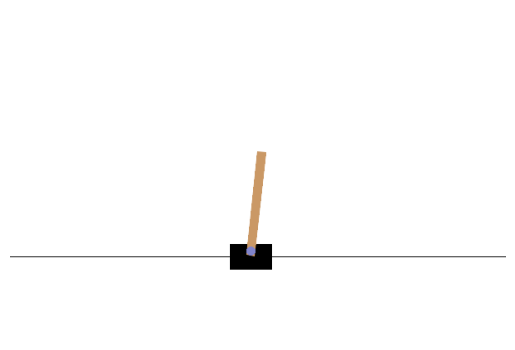

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import deque

import tensorflow as tf
from tensorflow import keras

from tqdm import tqdm
from tensorflow.keras import Sequential
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import math
from tensorflow.keras.regularizers import l2

from IPython import display
from pyvirtualdisplay import Display



class Model:
    def __init__(self, input_dim, output_dim, lr):
        #np.random.seed(1)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        #creamos dos redes, la principal y la target...
        self.Qpolicy = self.create()
        self.Qtarget = self.create()
        #Ahora copiamos la red principal en la target ...
        self.Qtarget.set_weights(self.Qpolicy.get_weights())

        self.d = Display()
        self.d.start()

    def create(self):
        modelo = Sequential()
        #capa fully conected con 512 neuronas, dimension de entrada input_dim y capa de activacion relu
        modelo.add(Dense(512, input_dim = self.input_dim, activation = 'relu'))
        #dimension de entrada es la salida de la capa anterior, aqui hay una capa con 256 neuronas y funcion de activacion relu
        modelo.add(Dense(256, activation = 'relu'))
        modelo.add(Dense(128, activation = 'relu'))
        modelo.add(Dense(self.output_dim, activation = 'linear'))
        modelo.summary()
        modelo.compile(optimizer = RMSprop(learning_rate = self.lr, rho = 0.95, epsilon = 0.01), loss = "mse", metrics = ['mse'])
        #modelo.compile(optimizer='adam',loss='mean_squared_error', metrics=['mean_squared_error'])

        return modelo

class DQNAgent:
    def __init__(self, lr = 2.5e-4, gamma = 0.99, epsilon = 1, decay_coe = 0.99975, min_eps = 0.001,
                 batch_size = 4, memory_size = 10_000, episodes = 5_000, C = 5):


        self.env = gym.make('CartPole-v1')
        print ("entorno inicializado ")
        input ("pulsa para seguir ....")

        self.dim_estado = len(self.env.observation_space.low)
        print ("longitud del estado ",self.dim_estado)
        self.n_actions = self.env.action_space.n

        self.actions = [i for i in range(self.n_actions)]
        print ("acciones: ",self.actions)

        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay_coe = decay_coe
        self.min_eps = min_eps
        self.episodes = episodes
        self.batch_size = batch_size
        #cuando se llega al limite (memory_size), los elementos mas antiguos se eliminan y se van anadiendo los nuevos
        self.D = deque(maxlen = memory_size) # replay memory
        self.C = C
        self.model = Model(self.dim_estado, self.n_actions, self.lr)
        self.states=len(self.env.observation_space.low)
        self.terminal_state=False

        self.target_counter = 0


    def choose_action(self, state):

        #esto es para comprobar que entiendo la parte del codigo correspondiente al else
        debug_else=True


        if np.random.random() > (1 - self.epsilon) and not(debug_else):
            accion = np.random.choice(self.actions)
        else:
            estado = np.array(state)
            estado=estado.reshape(1,self.dim_estado)
            print ("comprobamos la forma del patron que le vamos a meter a la red ", estado.shape)
            #input ("pulsa para seguir ...")
            #coge la accion maxima predicha por la red
            accion = np.argmax(self.model.Qpolicy.predict(estado))
            print ("accion predicha ",accion)
            #input ("hecho ")

        img = plt.imshow(self.env.render('rgb_array'))

        display.clear_output(wait=True)
        img.set_data(self.env.render('rgb_array'))
        plt.axis('off')
        display.display(plt.gcf())

        return accion


    def training(self):
        timestep_reward = 0

        for episode in range(self.episodes):
            print ("episodio: ",episode)
            #cogemos el estado
            estado_actual = self.env.reset()
            done = False
            score = 0
            while done != True:

                accion = self.choose_action(estado_actual)
                estado_siguiente,refuerzo,is_done, info = self.env.step(accion)

                self.terminal_state = done

                #se anhade al experience replay
                self.D.append([estado_actual, accion, refuerzo, estado_siguiente, is_done])
                #s_, r, done, _= self.env.step(a)

                # Rellenamos la pila de experimentos
                #self.es_estado_terminal = done
                #self.update_D(estado_actual,accion,refuerzo,estado_siguiente,done)

                #Es buena estrategia cambair el nombre de las variables
                print ("he ejecutado la accion ")
                estado_actual = estado_siguiente

                x=[]
                y=[]

                #si hay suficientes elementos en el experience replay
                if len(self.D)>=self.batch_size:
                  #cojo muestras aleatorias del tamanho de batch
                  aleatorio=random.sample(self.D, self.batch_size)

                  #para los estados actuales (primera columna) predigo los q valores
                  estados=np.array([row[0] for row in aleatorio]).reshape(-1,*np.array([row[0] for row in aleatorio]).shape)
                  qvalue=self.model.Qpolicy.predict(estados)[0]

                  #para los estados siguientes predigo los q_valores
                  estados_=np.array([row[3] for row in aleatorio]).reshape(-1,*np.array([row[3] for row in aleatorio]).shape)
                  qvalue_max=self.model.Qtarget.predict(estados_)[0]

                  #para cada muestra actualizo los q valores y las redes
                  for i, (estado_actual, accion, refuerzo, estado_siguiente, done) in enumerate(aleatorio):

                    if done:
                      Qtarget=refuerzo
                    else:
                      Qtarget=refuerzo+self.gamma*np.max(qvalue_max[i])

                    #valor q de mi estado actual i
                    qvalor_actual = qvalue[i]
                    #se actualiza el q_valor correspondiente a la accion ejecutada en el estado actual
                    qvalor_actual[accion] = Qtarget

                    x.append(estado_actual)
                    y.append(qvalor_actual)

                  #calculo el error
                  x, y = np.array(x).reshape(1,self.batch_size,1,self.states), np.array(y).reshape(1,self.batch_size, 1, self.n_actions)
                  print("QVALOR: ", qvalue)
                  loss = self.model.Qpolicy.fit(x, y, batch_size = self.batch_size, shuffle = False, verbose = 0)
                  print("----------------LOSS----------------")
                  print(loss.history['loss'])


                  if self.terminal_state:
                    self.target_counter+=1

                  #cada x pasos actualizo la red target (la target es mi red objetivo y se usa para calcular Q(a', s') con Bellman)
                  #pq la otra se esta cambiando continuamente y puede ser muy inestable
                  if self.target_counter > self.C:
                    self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
                    self.target_counter = 0


                  #self.train()
                estado_actual=estado_siguiente
                score+=refuerzo

            self.epsilon=self.epsilon*self.decay_coe




dqn = DQNAgent(episodes = 1_000)
dqn.training()
